# 중간 층에서 학습 측정하기

이 노트북에서 MNIST 숫자를 분류하는 간단한 완전 연결 신경망을 만들고 모델의 여러 은닉층에서 학습 속도를 조사하겠습니다.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rickiepark/dl-illustrated/blob/master/notebooks/8-3.measuring_speed_of_learning.ipynb)

#### 재현을 위해 랜덤 시드(seed) 값을 설정합니다.

In [1]:
import numpy as np
np.random.seed(42)

#### 라이브러리를 적재합니다.

In [2]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout # new!
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
%matplotlib inline

#### 사용자 정의 콜백을 정의합니다.

이 콜백은 에포크가 끝날 때마다 가중치를 구해 그레이디언트로 변환합니다. 이 그레이디언트는 딕셔너리에 저장되고 훈련이 종료될 때 에포크마다 각 층에서 얼마나 훈련이 빠르게 진행됐는지 측정하기 위해 유클리드 노름(Euclidean norm)을 계산합니다.

In [3]:
class GradHistory(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        # 은닉층의 목록을 만듭니다.
        self.layers = [layer for layer in self.model.layers if 'hidden_' in layer.name]
        
        # 빈 리스트로 그레이디언트 딕셔너리를 만듭니다.
        self.grads = {layer.name:[] for layer in self.layers}
        
        # 모델에서 초기 가중치를 가져옵니다.
        self.prev_w = [layer.get_weights()[0] for layer in self.layers]

    def on_epoch_end(self, batch, logs={}):
        # 에포크가 종료할 때 가중치를 얻습니다.
        curr_w = [layer.get_weights()[0] for layer in self.layers]
        
        # 학습률을 얻습니다.
        lr = K.get_value(self.model.optimizer.lr)
        
        # 이전 가중치와 현재 가중치를 그레이디언트로 변환합니다.
        grads_ = [(prev - curr) for curr, prev in zip(curr_w, self.prev_w)]
        
        # 그레이디언트를 딕셔너리에 저장합니다.
        for i,layer in enumerate(grads_):
            self.grads[self.layers[i].name].append(layer)
        self.prev_w = curr_w
    
    def on_train_end(self, logs={}):
        # 훈련이 끝나면 에포크마다 각 층의 그레이디언트의 배열의 유클리드 노름을 계산합니다.
        self.norms = {k:[np.sqrt(np.sum([x*x for x in epoch])) for epoch in v] for k,v in self.grads.items()}

#### 데이터를 적재합니다.

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


#### 데이터를 전처리합니다.

In [5]:
X_train = X_train.reshape(60000, 784).astype('float32')
X_test = X_test.reshape(10000, 784).astype('float32')

In [6]:
X_train /= 255
X_test /= 255

In [7]:
n_classes = 10
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

#### 신경망 구조를 만듭니다.

이 함수는 모델을 만들어 반환합니다.

In [8]:
def build_model(hidden = 2):
    
    model = Sequential()
    model.add(Dense(30, activation='sigmoid', input_shape=(784,),name='input'))
    
    for h in range(hidden):
        model.add(Dense(30, activation='sigmoid',name='hidden_{}'.format(h)))
    
    model.add(Dense(10, activation='softmax'))
    
    return model

#### 모델을 구성, 컴파일, 훈련합니다.


`build_model()` 함수를 호출한 다음 모델을 컴파일하고 훈련하여 (그레이디언트가 저장된) `history` 객체를 반환합니다.

In [9]:
def build_and_train(hidden = 1, epochs=200):
    
    model = build_model(hidden)
    history = GradHistory()
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    model.fit(X_train[:1000], y_train[:1000], batch_size=1, epochs=epochs, verbose=0, callbacks=[history])
    
    return history

`history.grads.norms`은 딕셔너리입니다. 키는 모델에 있는 층입니다. 각 키는 훈련의 모든 에포크에 걸친 그레이디언트 노름 값의 리스트를 가지고 있습니다.

In [10]:
# 모델을 만들고 훈련하기 위해 이 메서드를 호출하면 `history` 객체가 반환됩니다.
# 5개의 은닉층과 200번의 에포크를 사용합니다.
norms_5 = build_and_train(5, 200)

#### 그래프 출력 함수를 정의합니다.

In [11]:
def plot(history, hidden, log=False):   
    fig = plt.figure(figsize=(8,6),dpi=300)
    
    layers = [layer for layer in history.norms.keys()]
    values = [history.norms[layer] for layer in layers]
    
    for layer,values in zip(layers[::-1],values[::-1]):
        ys = np.array(values[:])
        xs = np.array(range(ys.shape[0]))
        ys_smooth = gaussian_filter1d(ys, sigma=3)
        plt.plot(xs, ys_smooth, label=layer)
        
    plt.title('Learning speed with {} hidden layers'.format(hidden))
    plt.ylabel('Learning speed')
    if log:
        plt.yscale('log')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

#### 결과를 출력합니다.

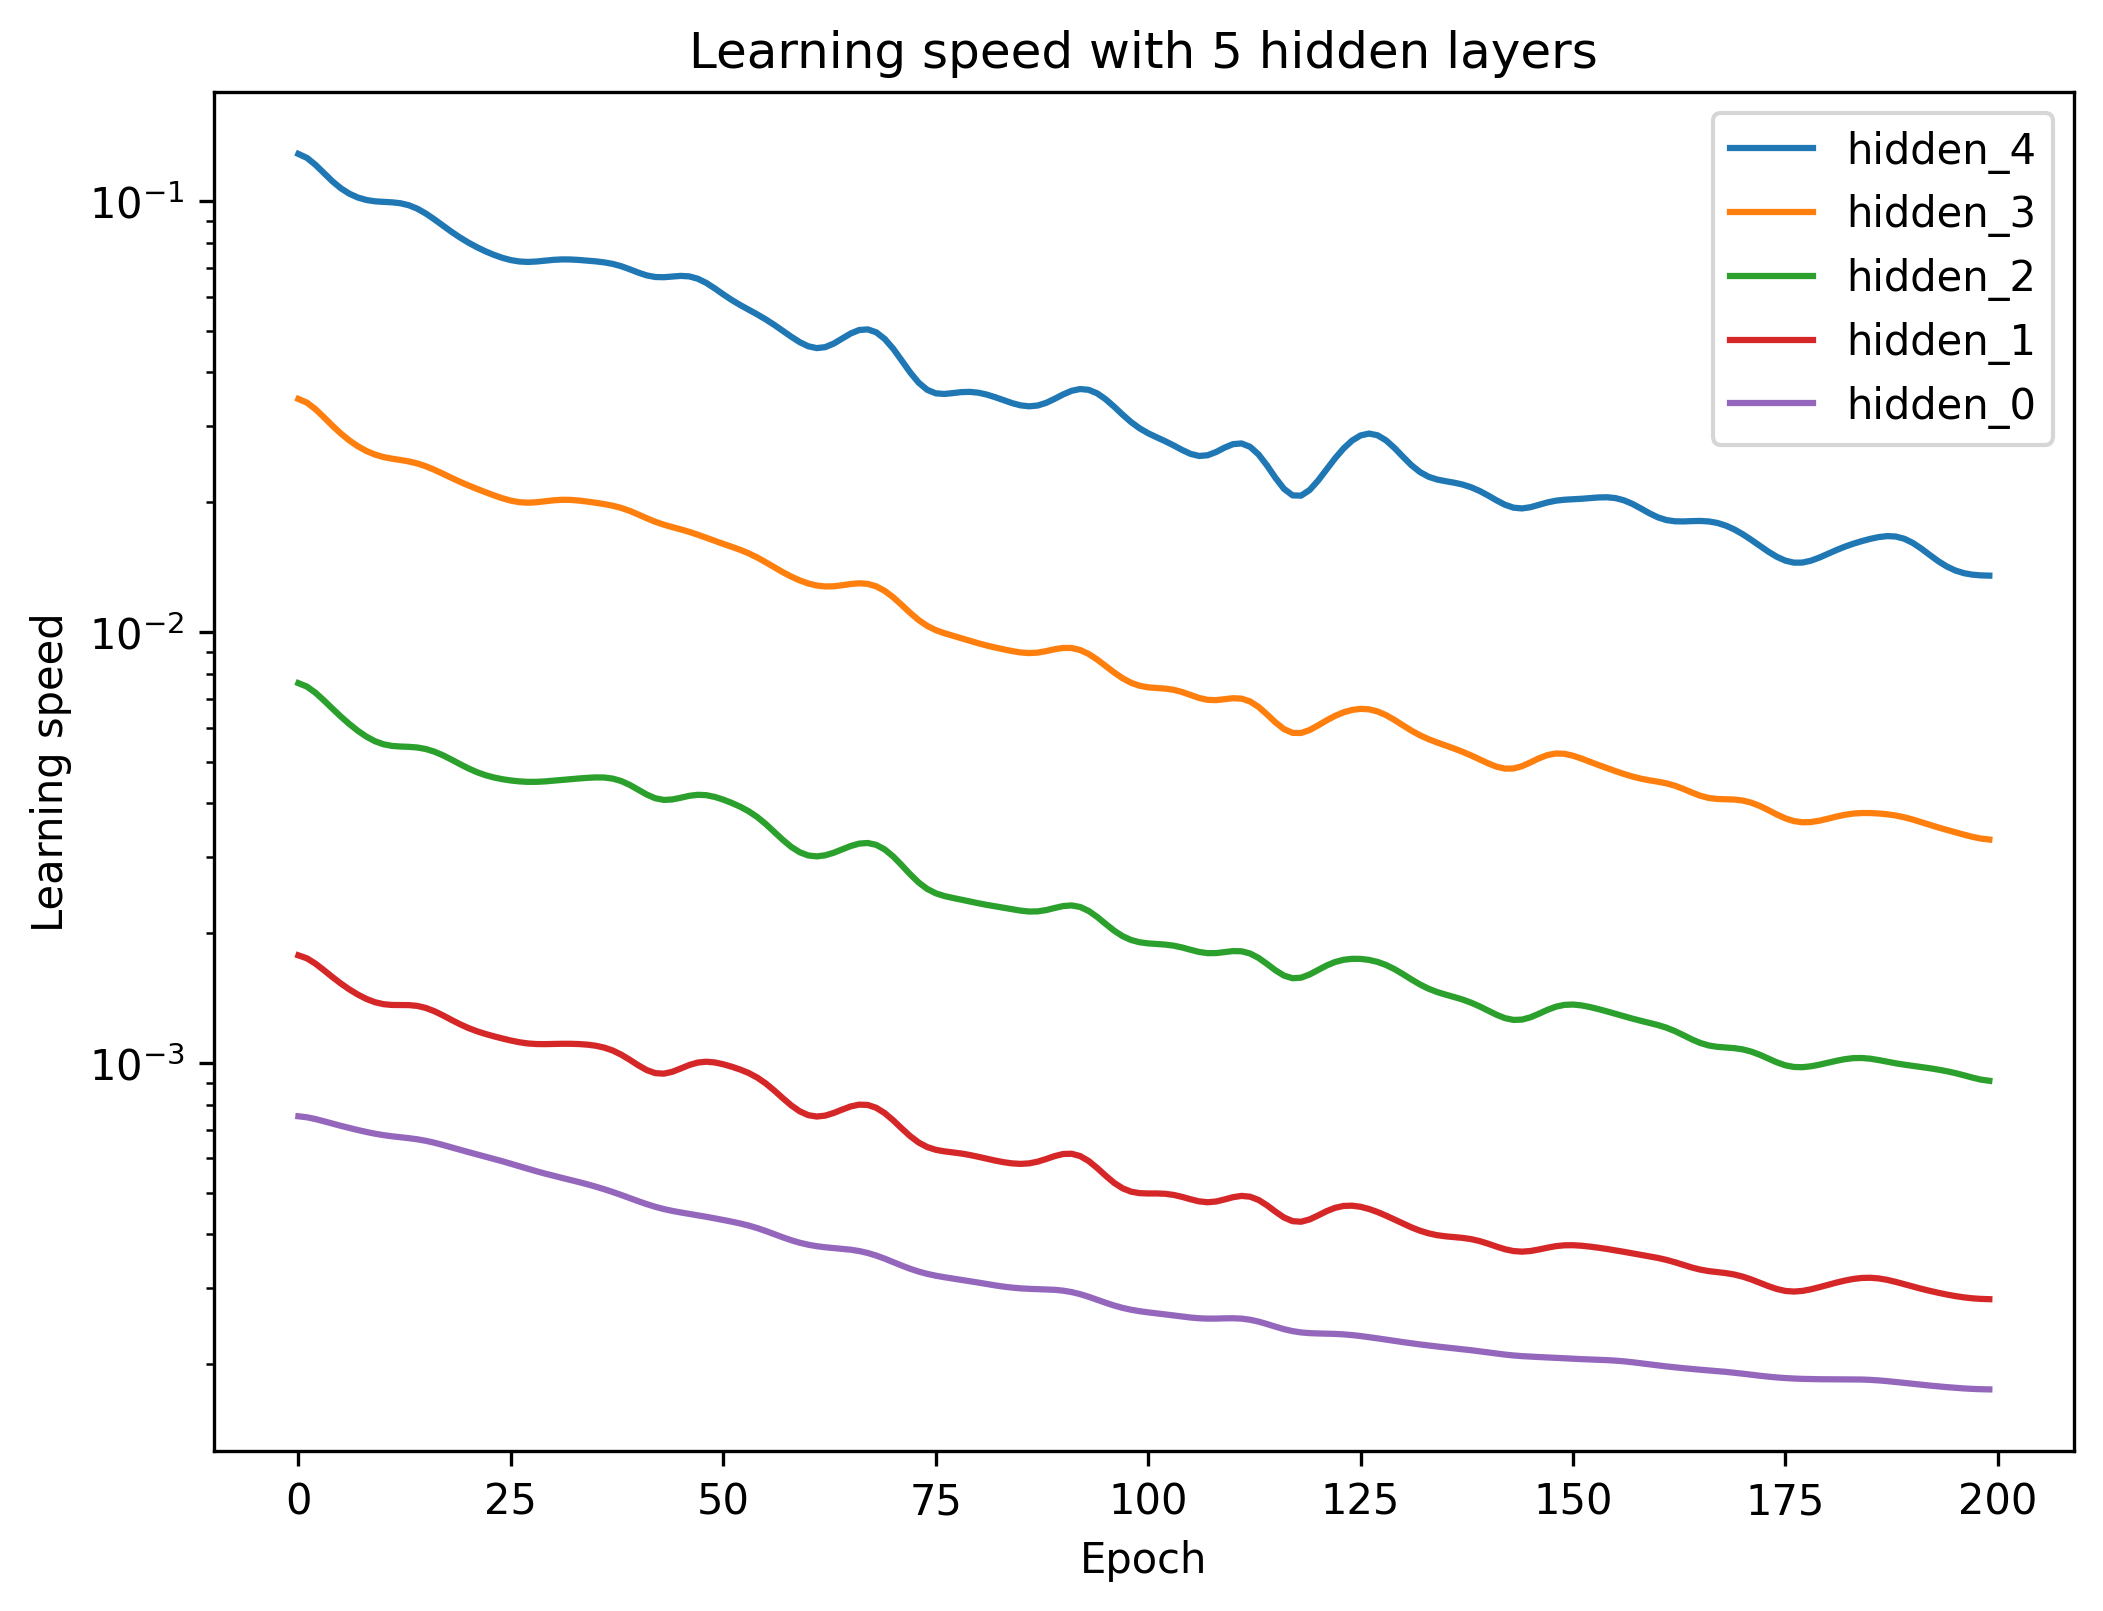

In [12]:
plot(norms_5, 5, True)